In [12]:
##Task 1: Minimal Reporting tool

import sqlite3
import pandas as pd

mydb_file = r'C:\Users\Pavillon Plus\Desktop\CV and Cover Letters\Flex Power\\trades.sqlite'

def list_all_objects():
    conn = sqlite3.connect (mydb_file)  #connecting to the trades database
    query = "SELECT name, type FROM sqlite_master;" #list all databases 
    objects = pd.read_sql_query (query, conn)
    conn.close ()

    return objects
    
objects_df = list_all_objects()
print("Databases:")
print(objects_df)


Databases:
                                  name   type
0                     epex_12_20_12_13  table
1  sqlite_autoindex_epex_12_20_12_13_1  index


In [13]:
#Task 1.1: Computing all buy trades and then adding respective quantity values  

def compute_total_buy_volume(df: pd.DataFrame) -> float:
    buy_volume = df [df['side']== 'buy']['quantity'].sum()
    return buy_volume

def compute_total_sell_volume(df: pd.DataFrame) -> float:
    sell_volume = df[df['side'] == 'sell']['quantity'].sum()
    return sell_volume

#Computing buy and sell volumes together 
def compute_all_volumes():
    conn = sqlite3.connect(mydb_file)
    trade_table = "epex_12_20_12_13"
    df = pd.read_sql_query(f'SELECT * FROM "{trade_table}"', conn)
    conn.close()
    total_buy = compute_total_buy_volume(df)
    print(f"Total Buy Volume: {total_buy} MW")
    
    total_sell = compute_total_sell_volume(df)
    print(f"Total Sell Volume: {total_sell} MW")

compute_all_volumes()

Total Buy Volume: 28 MW
Total Sell Volume: 53 MW


In [14]:
##Task 1.2: A function that computes the PnL (profit and loss) of each strategy (seperating all stratergies)

def compute_pnl(strategy_id: str, df: pd.DataFrame) -> float:
    strategy_trades = df[df['strategy'] == strategy_id]
    
    if strategy_trades.empty:
        return 0.0
        
    strategy_trades['income'] = strategy_trades.apply(
        lambda row: row['quantity'] * row['price'] if row['side'] == 'sell' else -row['quantity'] * row['price'], axis=1)
    
    total_pnl = strategy_trades['income'].sum()
    
    return total_pnl

In [17]:
def compute_pnl_for_all_strategies(df: pd.DataFrame):
    new_strategies = df['strategy'].unique()
    
    for strategy_id in new_strategies:
        pnl = compute_pnl(strategy_id, df)
        print(f"PnL for Strategy {strategy_id}: {pnl} EUR")

def process_trades_and_compute_pnl():
    conn = sqlite3.connect(mydb_file)
    trade_table = "epex_12_20_12_13"
    df = pd.read_sql_query(f'SELECT * FROM "{trade_table}"', conn)
    conn.close()
    
    print(df.head(6))
    compute_pnl_for_all_strategies(df)

process_trades_and_compute_pnl()


        id  quantity  price  side    strategy
0  trade_1         5   20.0   buy  strategy_1
1  trade_2        17   10.0  sell  strategy_1
2  trade_3        15    8.0   buy  strategy_1
3  trade_4        13   35.0  sell  strategy_2
4  trade_5        23   11.0  sell  strategy_2
5  trade_6         8   20.0   buy  strategy_2
PnL for Strategy strategy_1: -50.0 EUR
PnL for Strategy strategy_2: 548.0 EUR


C:\Users\Pavillon Plus\AppData\Local\Temp\ipykernel_15424\2991333500.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strategy_trades['income'] = strategy_trades.apply(
C:\Users\Pavillon Plus\AppData\Local\Temp\ipykernel_15424\2991333500.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strategy_trades['income'] = strategy_trades.apply(


In [18]:
#Task 1.3:  Create a entrypoint of a web application

# Initialize Flask App
from flask import Flask, jsonify
from flasgger import Swagger
from datetime import datetime

# Initialize Flask App
app = Flask(__name__)
swagger = Swagger(app)

# Database Configuration
DB_PATH = r'C:\Users\Pavillon Plus\Desktop\CV and Cover Letters\Flex Power\\trades.sqlite' 
TABLE_NAME = "epex_12_20_12_13"

def load_trades_data():
    conn = sqlite3.connect(DB_PATH)
    df = pd.read_sql_query(f'SELECT * FROM "{TABLE_NAME}"', conn)
    conn.close()
    return df

def compute_pnl(strategy_id: str, df: pd.DataFrame) -> float:
    strategy_trades = df[df['strategy'] == strategy_id]
    if strategy_trades.empty:
        return 0.0
    strategy_trades['income'] = strategy_trades.apply(
        lambda row: row['quantity'] * row['price'] if row['side'] == 'sell' else -row['quantity'] * row['price'],
        axis=1
    )
    return strategy_trades['income'].sum()

In [ ]:
#Entry point of the web application
app.view_functions.pop('get_pnl', None)

# API calls
@app.route('/v1/pnl/<strategy_id>', methods=['GET'])
def get_pnl(strategy_id):
    """
    Returns the PnL of the corresponding strategy.
    ---
    parameters:
      - name: strategy_id
        in: path
        type: string
        required: true
        description: Identifier of the strategy.
    responses:
      200:
        description: A PnL data object
        schema:
          type: object
          properties:
            strategy:
              type: string
              example: my_strategy
            value:
              type: float
              example: 100.0
            unit:
              type: string
              example: euro
            capture_time:
              type: string
              example: "2023-01-16T08:15:46Z"
    """
    try:
        df = load_trades_data()
        pnl_value = compute_pnl(strategy_id, df)
        response = {
            "strategy": strategy_id,
            "value": pnl_value,
            "unit": "euro",
            "capture_time": datetime.utcnow().isoformat() + "Z"
        }
        return jsonify(response), 200
    except Exception as e:
        return jsonify({"error": str(e)}), 500

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000, debug=True, use_reloader=False)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.98.185:5000
Press CTRL+C to quit


In [ ]:
#Test the API using Open Swagger Doc
# Go to : http://127.0.0.1:5000/apidocs
# For individual stratergy : http://127.0.0.1:5000/v1/pnl/strategy_id

In [5]:
##Task 2: Data analysis and building a trading strategy

import pandas as pd
import numpy as np
import pytz
import os 
import matplotlib.pyplot as plt

# Importing dataset values from excel

def load_analysis_data():
    datafile = r'C:\Users\Pavillon Plus\Desktop\CV and Cover Letters\Flex Power\analysis_task_data.xlsx'
    analysis_data = pd.read_excel(datafile)
    
    print("First values of Excel Data:")  # Displaying the first few rows
    print(analysis_data.head())
    
    return analysis_data

analysis_data = load_analysis_data()

First values of Excel Data:
   hour                time  Wind Day Ahead Forecast [in MW]  \
0     0 2021-01-01 00:00:00                             4433   
1     0 2021-01-01 00:15:00                             4286   
2     0 2021-01-01 00:30:00                             4142   
3     0 2021-01-01 00:45:00                             3991   
4     1 2021-01-01 01:00:00                             3847   

   Wind Intraday Forecast [in MW]  PV Day Ahead Forecast [in MW]  \
0                            4709                              0   
1                            4507                              0   
2                            4307                              0   
3                            4181                              0   
4                            4094                              0   

   PV Intraday Forecast [in MW]  Day Ahead Price hourly [in EUR/MWh]  \
0                             0                                50.87   
1                             0   

In [4]:
#Task 2.1:Calculate Total Wind Forecast in MWh

def calculate_wind_forecast_energy(data):
    conversion_factor = 0.25  #conversion factor to convert in MWh 

    # Wind Day Ahead and Intraday Forecasts
    wind_day_ahead_mwh = data['Wind Day Ahead Forecast [in MW]'].sum()*conversion_factor
    wind_intraday_mwh = data['Wind Intraday Forecast [in MW]'].sum() *conversion_factor

    print(f"Total Wind Power Forecast (Day Ahead) in 2021: {wind_day_ahead_mwh:.1f} MWh")
    print(f"Total Wind Power Forecast (Intraday) in 2021: {wind_intraday_mwh:.1f} MWh")

    return wind_day_ahead_mwh, wind_intraday_mwh

wind_day_ahead_mwh, wind_intraday_mwh = calculate_wind_forecast_energy(analysis_data)

Total Wind Power Forecast (Day Ahead) in 2021: 115395406.2 MWh
Total Wind Power Forecast (Intraday) in 2021: 113478034.5 MWh


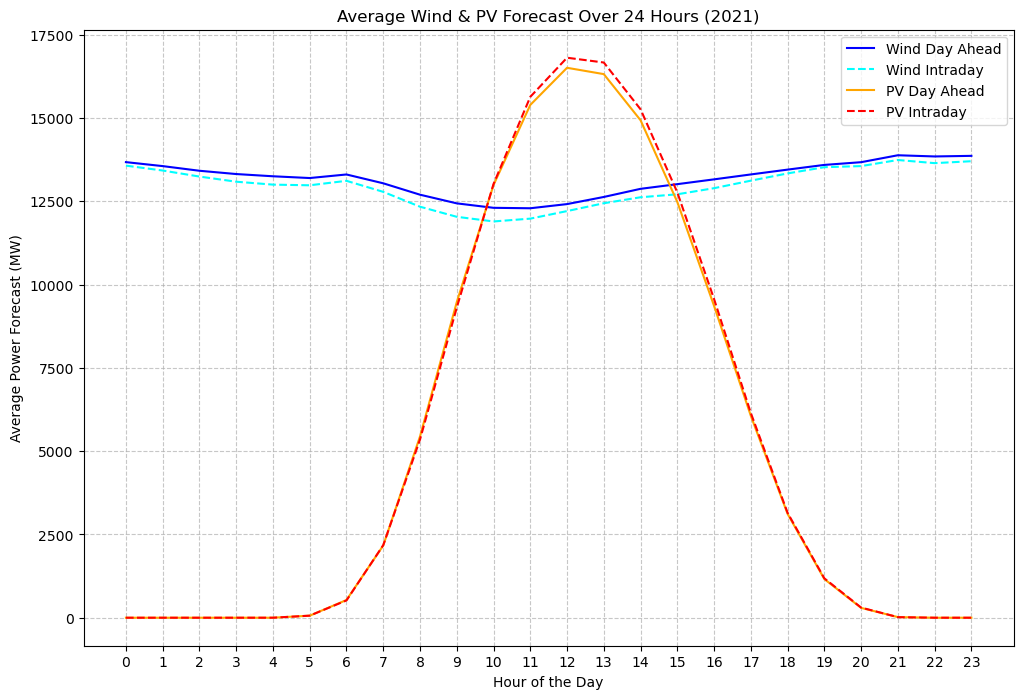

In [6]:
# Task 2.2: Calculate average forecasts of Wind and Solar over a 24-hour period

def calculate_average_forecast(data):
    data['time'] = pd.to_datetime(data['time'])
    data['hour_of_day'] = data['time'].dt.hour

    avg_wind_da = data.groupby('hour_of_day')['Wind Day Ahead Forecast [in MW]'].mean()
    avg_wind_id = data.groupby('hour_of_day')['Wind Intraday Forecast [in MW]'].mean()
    avg_pv_da = data.groupby('hour_of_day')['PV Day Ahead Forecast [in MW]'].mean()
    avg_pv_id = data.groupby('hour_of_day')['PV Intraday Forecast [in MW]'].mean()

    return avg_wind_da, avg_wind_id, avg_pv_da, avg_pv_id

# Plot the data values
def plot_average_forecast(avg_wind_da, avg_wind_id, avg_pv_da, avg_pv_id):
    
    plt.figure(figsize=(12, 8))
    plt.plot(avg_wind_da, label='Wind Day Ahead', color='blue', linestyle='-')
    plt.plot(avg_wind_id, label='Wind Intraday', color='cyan', linestyle='--')
    plt.plot(avg_pv_da, label='PV Day Ahead', color='orange', linestyle='-')
    plt.plot(avg_pv_id, label='PV Intraday', color='red', linestyle='--')

   
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Power Forecast (MW)')
    plt.title('Average Wind & PV Forecast Over 24 Hours (2021)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.xticks(range(0, 24))  

    plt.show()

avg_wind_da, avg_wind_id, avg_pv_da, avg_pv_id = calculate_average_forecast(analysis_data)
plot_average_forecast(avg_wind_da, avg_wind_id, avg_pv_da, avg_pv_id)

In [7]:
# Task 2.3: Calculate the average value for Wind/PV using Day Ahead Forecasts and DA Prices

def compare_average_da_price(data):
    da_price = data['Day Ahead Price hourly [in EUR/MWh]']
    wind_da_forecast = data['Wind Day Ahead Forecast [in MW]']
    pv_da_forecast = data['PV Day Ahead Forecast [in MW]']

    
    avg_value_wind = (wind_da_forecast * da_price).sum() / wind_da_forecast.sum()
    avg_value_pv = (pv_da_forecast * da_price).sum() / pv_da_forecast.sum()
    avg_da_price = da_price.mean()

    print(f"Average Value for Wind Power: {avg_value_wind:.1f} EUR/MWh")
    print(f"Average Value for PV Power: {avg_value_pv:.1f} EUR/MWh")
    print(f"Average Day Ahead Price: {avg_da_price:.1f} EUR/MWh")

    print("\nComparison:")
    print(f"- Wind Average Value is {'higher' if avg_value_wind > avg_da_price else 'lower'} than the average DA price.")
    print(f"- PV Average Value is {'higher' if avg_value_pv > avg_da_price else 'lower'} than the average DA price.")


compare_average_da_price(analysis_data)


Average Value for Wind Power: 81.4 EUR/MWh
Average Value for PV Power: 76.9 EUR/MWh
Average Day Ahead Price: 96.8 EUR/MWh

Comparison:
- Wind Average Value is lower than the average DA price.
- PV Average Value is lower than the average DA price.


In [ ]:
""" Is the average value of Wind and PV higher or lower than the average da price? Why could it be higher/lower?

Typically the price of avg value of day ahead prices of Wind and PV are lower than avg day ahead market price. This could happen due to several reasons such as

1. In the merit order, renewables such as wind and solar clears the production list earlier (due to low OPEX and zero marginal cost) than other technologies 
#and pushes expensive generation unit out of the market during periods of high renewable production.

2. This could also happen due to canabilization effect, when many renewable generators produce simultaneously,they suppress market prices during their peak generation periods.
"""


In [8]:
# Task 2.4 - Identify Days with Highest & Lowest Renewable Production

def renewable_energy_p_p(data):
    
    data['time'] = pd.to_datetime(data['time'])
    data['date'] = data['time'].dt.date


    data['total_renewable_production'] = (data['Wind Day Ahead Forecast [in MW]'] + data['PV Day Ahead Forecast [in MW]'])
    daily_production = data.groupby('date')['total_renewable_production'].sum()

   
    max_prod_date = daily_production.idxmax()
    min_prod_date = daily_production.idxmin()
    max_prod_day_data = data[data['date'] == max_prod_date]
    min_prod_day_data = data[data['date'] == min_prod_date]
    
    avg_da_price_max_prod = max_prod_day_data['Day Ahead Price hourly [in EUR/MWh]'].mean()
    avg_da_price_min_prod = min_prod_day_data['Day Ahead Price hourly [in EUR/MWh]'].mean()

    # printing the values of total RE production , day and avg DA price
    print(f"Day with Highest Renewable Production: {max_prod_date}")
    print(f" - Total Production: {daily_production[max_prod_date]:,.1f} MWh")
    print(f" - Average DA Price: {avg_da_price_max_prod:.1f} EUR/MWh\n")

    print(f"Day with Lowest Renewable Production: {min_prod_date}")
    print(f" - Total Production: {daily_production[min_prod_date]:,.1f} MWh")
    print(f" - Average DA Price: {avg_da_price_min_prod:.1f} EUR/MWh\n")

    # Calculating DA Price difference between high RE procution to low
    price_diff = avg_da_price_max_prod - avg_da_price_min_prod
    print(f"Price Difference: {price_diff:.1f} EUR/MWh")

renewable_energy_p_p(analysis_data)

Day with Highest Renewable Production: 2021-03-12
 - Total Production: 4,352,164.0 MWh
 - Average DA Price: 22.3 EUR/MWh

Day with Lowest Renewable Production: 2021-11-16
 - Total Production: 236,797.0 MWh
 - Average DA Price: 237.5 EUR/MWh

Price Difference: -215.2 EUR/MWh


In [ ]:
"""how do you expalin the price difference Avg DA Price from Highest to Lowest?
This could happen due to two reasons 
1. In case of low RE production due to weather conditions and high average day ahead prices, the hourly demand needs to be achieved by expensive geneartors or peaking power plants
such as gas or diesal reciprocant engine peakers which increases the avg DA prices. In case of high RE production, market clearing prices are reduced due to ample supply by Wind and solar or low demand on the day. 
This leads to lower DA prices and sometimes negtive prices. This challenge of negtive pricing could be solve by energy strorage units :)

"""

In [9]:
# Task 2.5 Average day ahead price on weekdays vs weekends

def avg_da_price_w_w(data):
    data['time'] = pd.to_datetime(data['time'])
    data['day_of_week'] = data['time'].dt.dayofweek
    data['day_type'] = data['day_of_week'].apply(lambda x: 'Weekday' if x < 5 else 'Weekend')


    avg_prices = data.groupby('day_type')['Day Ahead Price hourly [in EUR/MWh]'].mean()
    
    print(f"Average Day Ahead Price on Weekdays: {avg_prices['Weekday']:.1f} EUR/MWh")
    print(f"Average Day Ahead Price on Weekends: {avg_prices['Weekend']:.1f} EUR/MWh")
    price_diff = avg_prices['Weekday'] - avg_prices['Weekend']
    print(f"\nPrice Difference (Weekday - Weekend): {price_diff:.1f} EUR/MWh")

avg_da_price_w_w(analysis_data)

Average Day Ahead Price on Weekdays: 104.4 EUR/MWh
Average Day Ahead Price on Weekends: 78.0 EUR/MWh

Price Difference (Weekday - Weekend): 26.4 EUR/MWh


In [ ]:
"""how do you expalin the price difference Avg DA Price from Highest to Lowest ?
Typically it happens due to supply and demand reason. For example on a weekday industries, offices, schools and co working spaces 
draw more power simuntaneously which leads to higher DA prices on weekdays.


In [12]:
# Task 2.6 Connecting Battery Storage and Calculating Revenue 

def battery_revenue(data):
    data['time'] = pd.to_datetime(data['time'])
    data['date'] = data['time'].dt.date
    
    daily_revenue = [] #calculating daily revenue 

    for date, day_data in data.groupby('date'):
        # Logic 1 : Charging battery at lowest price and discharging at highest for the day
        min_price = day_data['Day Ahead Price hourly [in EUR/MWh]'].min()
        max_price = day_data['Day Ahead Price hourly [in EUR/MWh]'].max()

        # Logic 2: Taking the AC by AC efficieny of 1 MWh battery system as 0.95 considering some system losses
        daily_profit = 0.95 * (max_price - min_price)  
        daily_revenue.append(daily_profit)

    total_revenue = sum(daily_revenue)

    print(f"Total Annual Revenue from Battery in 2021: {total_revenue:.1f} EUR")
    print(f"Average Daily Revenue: {total_revenue / len(daily_revenue):.1f} EUR/day")

battery_revenue(analysis_data)

Total Annual Revenue from Battery in 2021: 27846.0 EUR
Average Daily Revenue: 76.3 EUR/day


Total Profit for the Year: 2.6 Million EUR


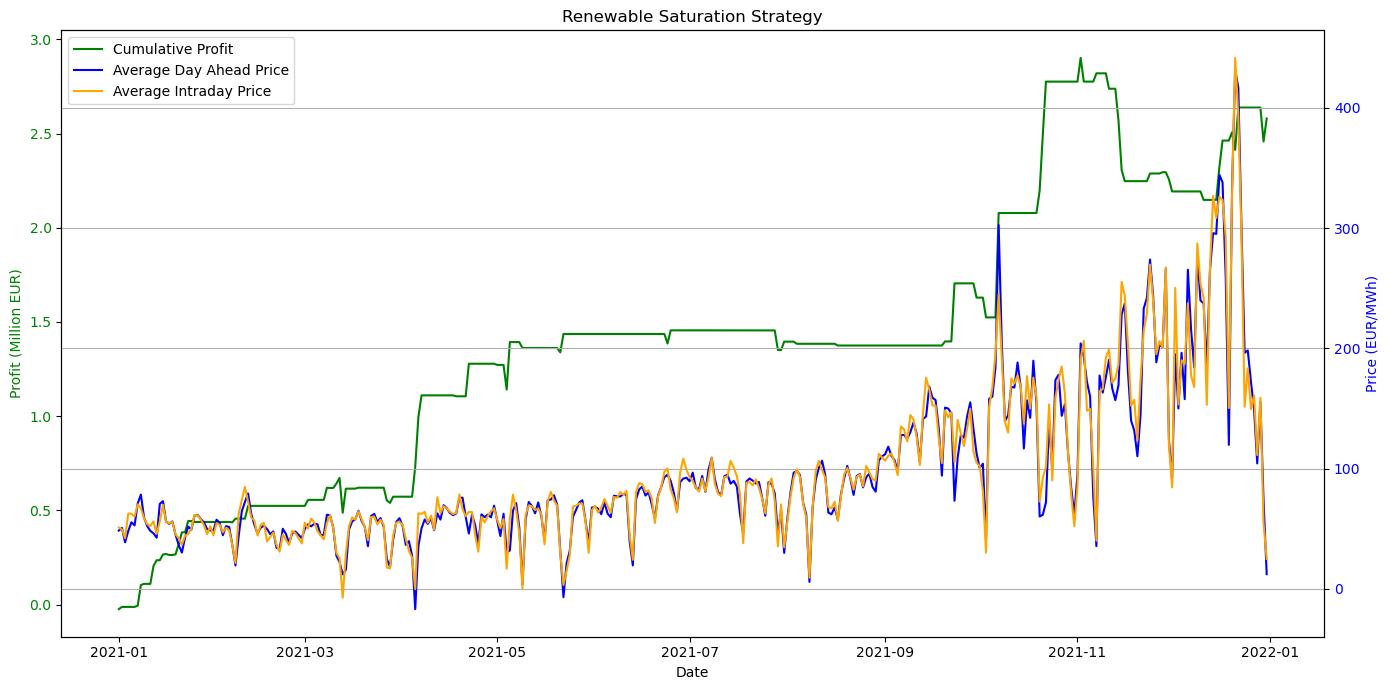

In [16]:
#Task 2.7 Designing a new stratergy (Renewable Saturation Strategy)

#Logic 1: Identify High and Low Renewable generation days 
#Logic 2: High production days having short DA prices and long ID prices
#Logic 3: Low production days having long DA prices and short prices

file_path = r'C:\Users\Pavillon Plus\Desktop\CV and Cover Letters\Flex Power\analysis_task_data.xlsx'
data = pd.read_excel(file_path)

data['time'] = pd.to_datetime(data['time'])
data['date'] = data['time'].dt.date

data['total_renewable_forecast'] = (data['Wind Day Ahead Forecast [in MW]'] + data['PV Day Ahead Forecast [in MW]']) * 0.25 
daily_renewables = data.groupby('date')['total_renewable_forecast'].sum()

# Percentile-based method for identying high and low RE gen days
high_threshold = daily_renewables.quantile(0.9)
low_threshold = daily_renewables.quantile(0.1)

# Merge daily renewables back to original data
data = data.merge(daily_renewables.rename('daily_total_renewable'), on='date')

# Trading Strategy Logic
def apply_strategy(row):
    da_price = row['Day Ahead Price hourly [in EUR/MWh]']
    id_price = row['Intraday Price Hourly  [in EUR/MWh]']
    position = 100  #MW

    if row['daily_total_renewable'] >= high_threshold: # High production day: Short DA, Long ID      
        return (id_price - da_price) * position
    elif row['daily_total_renewable'] <= low_threshold: # Low production day: Long DA, Short ID       
        return (da_price - id_price) * position
    else:
        return 0

# Calculating the profits
data['profit'] = data.apply(apply_strategy, axis=1)

# Cumulative profit (in million EUR) and total profit for the entire year
cumulative_profit = data.groupby('date')['profit'].sum().cumsum() / 1_000_000  
total_profit_million_eur = cumulative_profit.iloc[-1]
print(f"Total Profit for the Year: {total_profit_million_eur:.1f} Million EUR")

# Aggregate daily average prices
avg_da_price = data.groupby('date')['Day Ahead Price hourly [in EUR/MWh]'].mean()
avg_id_price = data.groupby('date')['Intraday Price Hourly  [in EUR/MWh]'].mean()

# Plot cumulative performance and prices in one graph with dual y-axes
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.plot(cumulative_profit, label='Cumulative Profit', color='green')
ax1.set_xlabel('Date')
ax1.set_ylabel('Profit (Million EUR)', color='green')  
ax1.tick_params(axis='y', labelcolor='green')


ax2 = ax1.twinx()
ax2.plot(avg_da_price, label='Average Day Ahead Price', color='blue')
ax2.plot(avg_id_price, label='Average Intraday Price', color='orange')
ax2.set_ylabel('Price (EUR/MWh)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Renewable Saturation Strategy')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
""" Reasoning: 
1. It works well in markets with volatile renewable generation 
2. Also, it takes advantage of both forecast errors and market corrections

Cons
1. Any regulatory interventions (like price caps) can limit profits
2. Any sudden weather changes may cause unexpected price swings
3. Needs to set an absolute thresholds based on historical energy production data

"""